In [1]:
import keras
import numpy as np
from keras import activations

Using TensorFlow backend.


In [2]:
from keras import layers


def residual_block(y, nb_channels, _strides=(1, 1), _project_shortcut=False):
    shortcut = y

    # down-sampling is performed with a stride of 2
    y = layers.Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)
    y = layers.BatchNormalization()(y)
    y = layers.LeakyReLU()(y)

    y = layers.Conv2D(nb_channels, kernel_size=(3, 3), strides=(1, 1), padding='same')(y)
    y = layers.BatchNormalization()(y)

    # identity shortcuts used directly when the input and output are of the same dimensions
    if _project_shortcut or _strides != (1, 1):
        # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
        # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
        shortcut = layers.Conv2D(nb_channels, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    y = layers.add([shortcut, y])

    return y


In [3]:
from keras.models import Input, Model
from keras.layers import Conv2D
from keras.layers import Deconv2D

In [4]:
import tensorflow as tf
from keras.engine.topology import Layer
from keras.engine import InputSpec

class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def get_output_shape_for(self, s):
        """ If you are using "channels_last" configuration"""
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')

# a little Demo
#inputs = Input((img_rows, img_cols, num_channels))
#padded_inputs = ReflectionPadding2D(padding=(1,1))(inputs)
#conv1 = Conv2D(32, 3, padding='valid', kernel_initializer='he_uniform',
#               data_format='channels_last')(padded_inputs)


In [5]:
"""
In this cell I define, functionally, the "image transformation" network from jc johnson's and li fei fei paper.
"""

inputs = Input(shape=[256, 256, 3])
o = ReflectionPadding2D(padding=(40,40))(inputs) #TODO: Check if the reflection padding is done as the paper
o = Conv2D(32, (9, 9), strides=(1,1))(o)
o = Conv2D(64, (3, 3), strides=(2,2))(o)
o = Conv2D(128, (3, 3), strides=(2,2))(o)
o = residual_block(o, 128)
o = residual_block(o, 128)
o = residual_block(o, 128)
o = residual_block(o, 128) #TODO: check if the residual blocks are the same as the paper
o = residual_block(o, 128)
o = Deconv2D(64, (3, 3), strides=2)(o)
o = Deconv2D(32, (3, 3), strides=2)(o) #TODO: check if the output of this layer is the same as the fractional stride conv
o = Conv2D(3, (9, 9), strides=1, activation='tanh')(o)

model_style_transfer = Model(inputs=inputs, outputs=o)


c:\program files\python36\lib\site-packages\keras\engine\topology.py:636: UserWarning: Class `__main__.ReflectionPadding2D` defines `get_output_shape_for` but does not override `compute_output_shape`. If this is a Keras 1 layer, please implement `compute_output_shape` to support Keras 2.
  output_shape = self.compute_output_shape(input_shape)


In [6]:
from keras.applications import VGG16

In [7]:
vgg = VGG16(include_top=False)

In [97]:
vgg.layers # let's see where to get our outputs for style

In [69]:
relu1_2 = Model(inputs=[vgg.get_layer(index=0).input], outputs=[vgg.get_layer(index=2).output])
relu2_2 = Model(inputs=[vgg.get_layer(index=0).input], outputs=[vgg.get_layer(index=5).output])
relu3_3 = Model(inputs=[vgg.get_layer(index=0).input], outputs=[vgg.get_layer(index=9).output])
relu4_3 = Model(inputs=[vgg.get_layer(index=0).input], outputs=[vgg.get_layer(index=13).output])

In [70]:
import cv2

In [71]:
im = cv2.imread("fortnite/34.png")

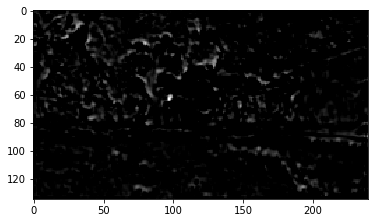

In [95]:
provaoutput = relu4_3.predict(np.array([im]))[0,:,:,83]

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(provaoutput, cmap='gray')
plt.show()

In [68]:
import tensorflow as tf

def custom_objective(y_true, y_pred):
    '''Just another crossentropy'''
    y_true = tf.Variable(trainable=False, initial_value=tf.float32(0.0))
    distance = y_pred - y_true
    return distance

def gram_matrix(x):
    if K.image_dim_ordering() == 'th':
        features = K.batch_flatten(x)
    else:
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))

    shape = K.shape(x)
    
    C, W, H = (shape[0],shape[1], shape[2])
    
    cf = K.reshape(features ,(C,-1))
    gram = K.dot(cf, K.transpose(cf)) /  K.cast(C*W*H,dtype='float32')

    return gram




In [47]:
from keras import backend as K
prova.add_loss(custom_objective)

def dummy_loss(y_true, y_pred ):
    return K.variable(0.0)

In [96]:
style_gram_1 = gram_matrix(relu1_2.predict(np.array([im]))[0])
style_gram_2 = gram_matrix(relu2_2.predict(np.array([im]))[0])
style_gram_3 = gram_matrix(relu3_3.predict(np.array([im]))[0])
style_gram_4 = gram_matrix(relu4_3.predict(np.array([im]))[0])